In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv("../input_data/yellow_tripdata_2020-01.csv", low_memory=False)\
       .dropna()[['passenger_count', 'trip_distance', 'tip_amount']]
df = df[df.trip_distance > 0][df.tip_amount >= 0]

Проанализируем гистограммы с разным порогом отсечения снизу величины чаевых:

In [3]:
df0 = df[df.tip_amount == 0]
dft = df[df.tip_amount > 0]
df2 = df[df.tip_amount > 2]
df5 = df[df.tip_amount > 5]
df10 = df[df.tip_amount > 10]
df25 = df[df.tip_amount > 25]
df50 = df[df.tip_amount > 50]


def hist(df, title):
    plt.figure(figsize=(14, 4))
    plt.subplot(1, 3, 1)
    sns.histplot(data=df, x="passenger_count", discrete=True)
    plt.subplot(1, 3, 2)
    plt.title(title)
    sns.histplot(data=df, x="trip_distance", bins=30, log_scale=True)
    plt.subplot(1, 3, 3)
    sns.histplot(data=df, x=df.tip_amount + 0.01, bins=30, log_scale=True)
    plt.show()

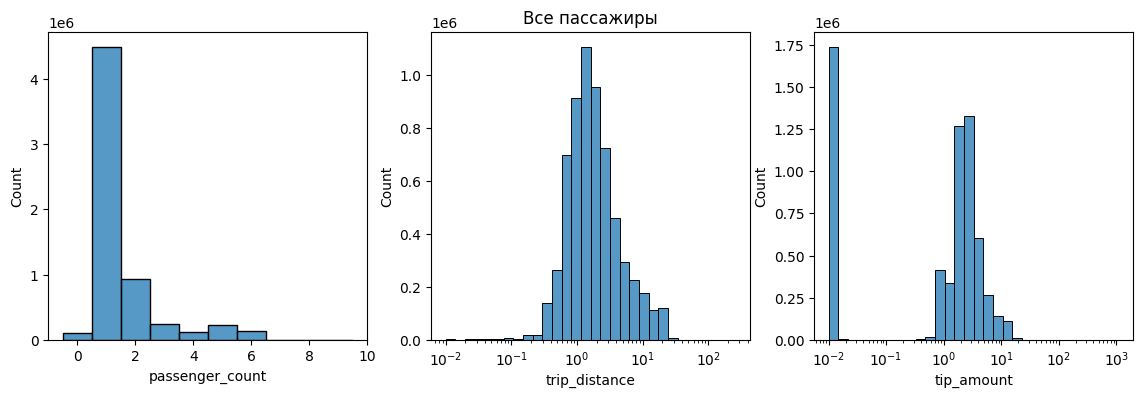

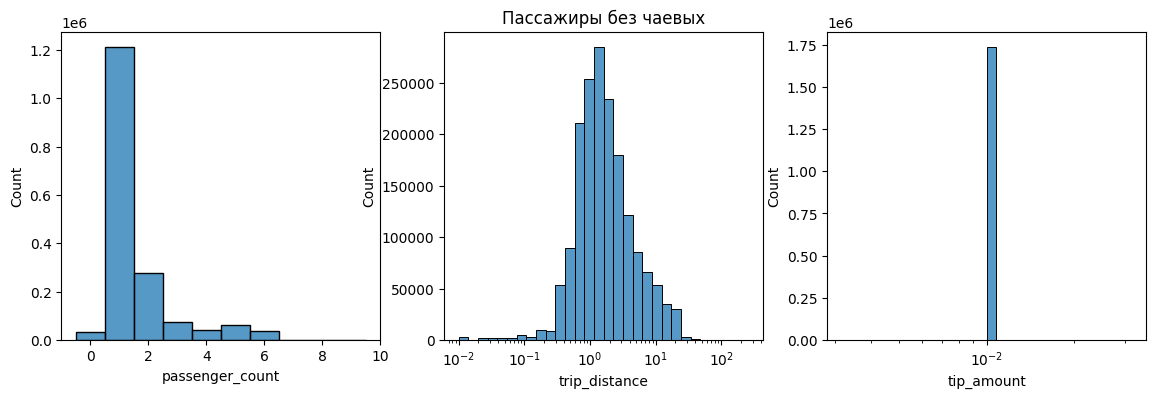

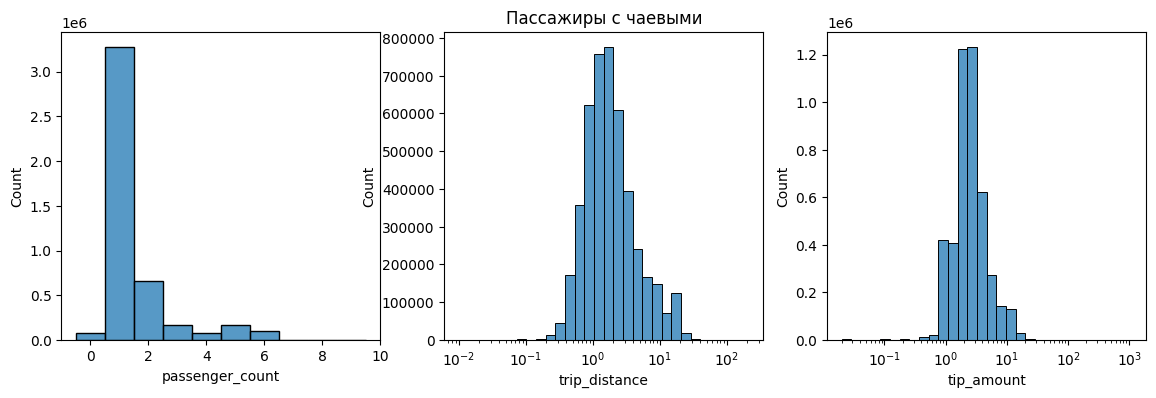

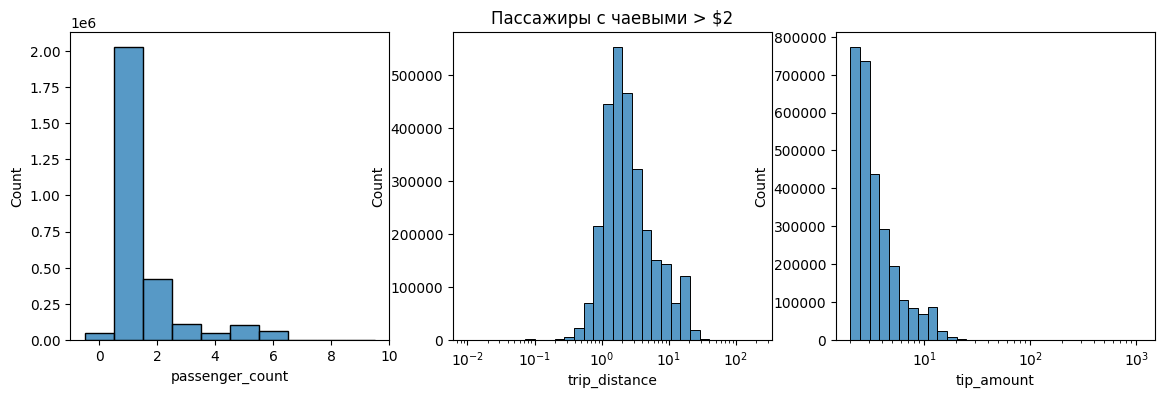

In [4]:
hist(df, "Все пассажиры")
hist(df0, "Пассажиры без чаевых")
hist(dft, "Пассажиры с чаевыми")
hist(df2, "Пассажиры с чаевыми > $2")

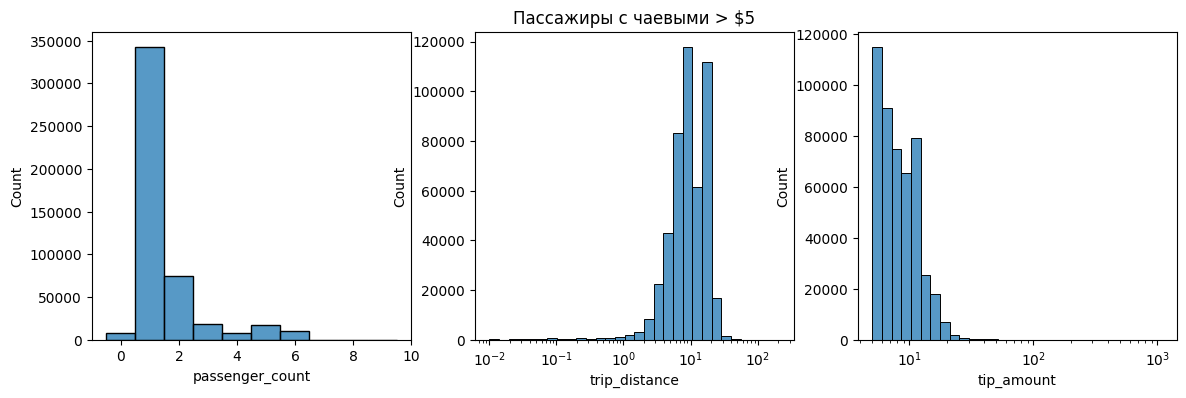

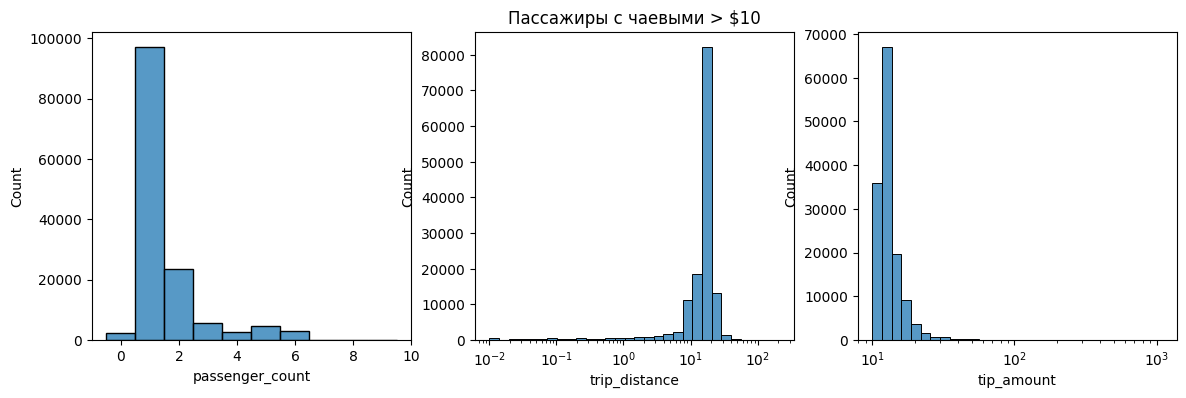

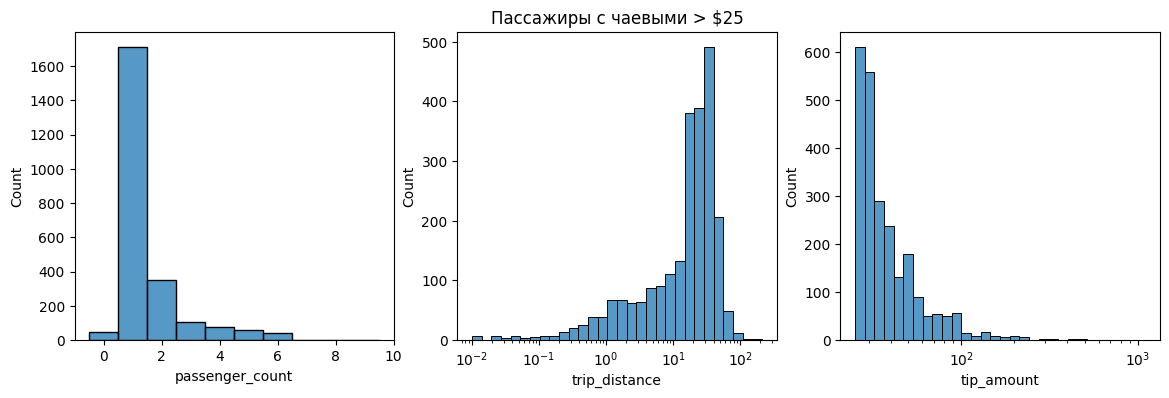

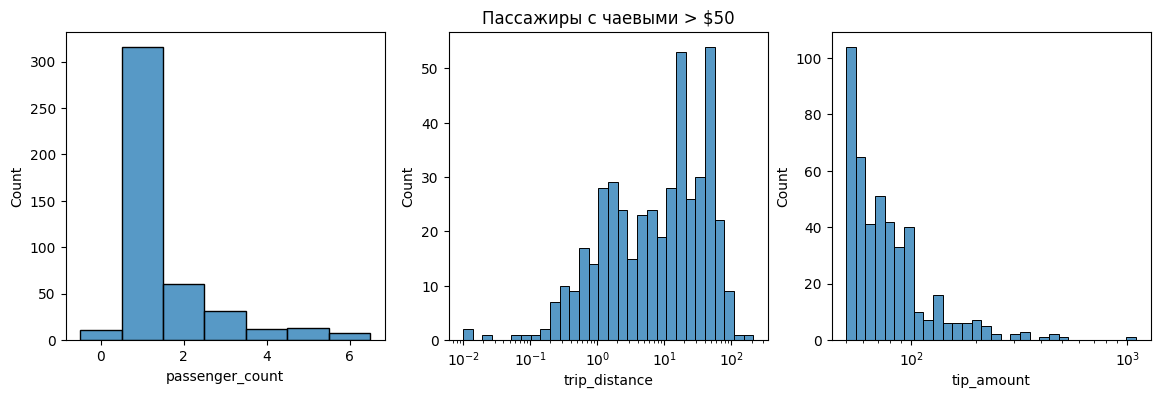

In [5]:
hist(df5, "Пассажиры с чаевыми > $5")
hist(df10, "Пассажиры с чаевыми > $10")
hist(df25, "Пассажиры с чаевыми > $25")
hist(df50, "Пассажиры с чаевыми > $50")

Видим, что по мере роста порога отсечения, гистограмма расстояния поездки сдвигается вправо и меняет форму. В то же время, гистограмма числа пассажиров практически не меняется. Продолжим исследование зависимости между чаевыми и расстоянием, для этого разобъем диапазон чаевых на интервалы вида (base^n, base^(n+1)) и для каждого интервала посчитаем медиану и среднее расстояния:

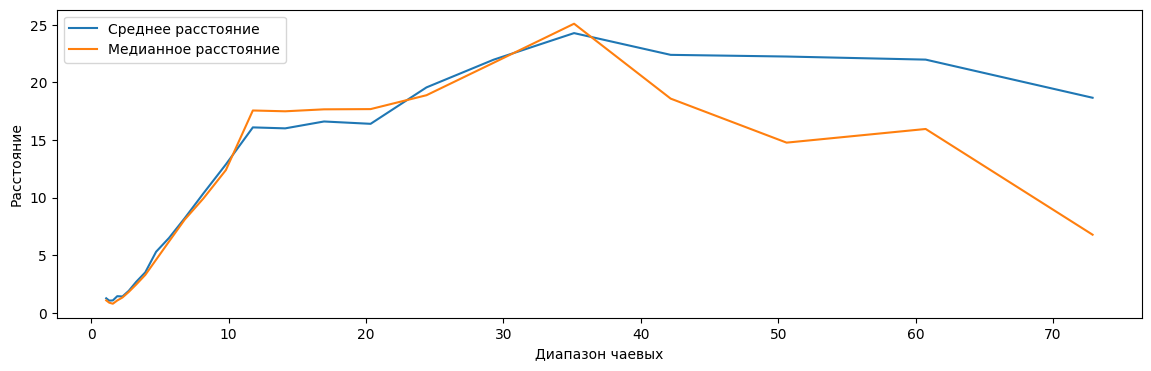

In [6]:
list_arg = []
list_mean = []
list_median = []
base = 1.2
rng = 24

for n in range(rng):
    lower = base**n
    upper = base**(n + 1)
    dfn = df.trip_distance[lower < df.tip_amount][df.tip_amount <= upper]
    list_arg.append((lower + upper) / 2)
    list_mean.append(dfn.mean())
    list_median.append(dfn.median())
    
plt.figure(figsize=(14, 4))
plt.plot(list_arg, list_mean, label='Среднее расстояние')
plt.plot(list_arg, list_median, label='Медианное расстояние')
plt.xlabel("Диапазон чаевых")
plt.ylabel("Расстояние")
plt.legend()
plt.show()

Обращает на себя внимание практически линейный рост на дистанциях до 15-17 (скорее всего миль). 
Исследуем зависимость от числа пассажиров:

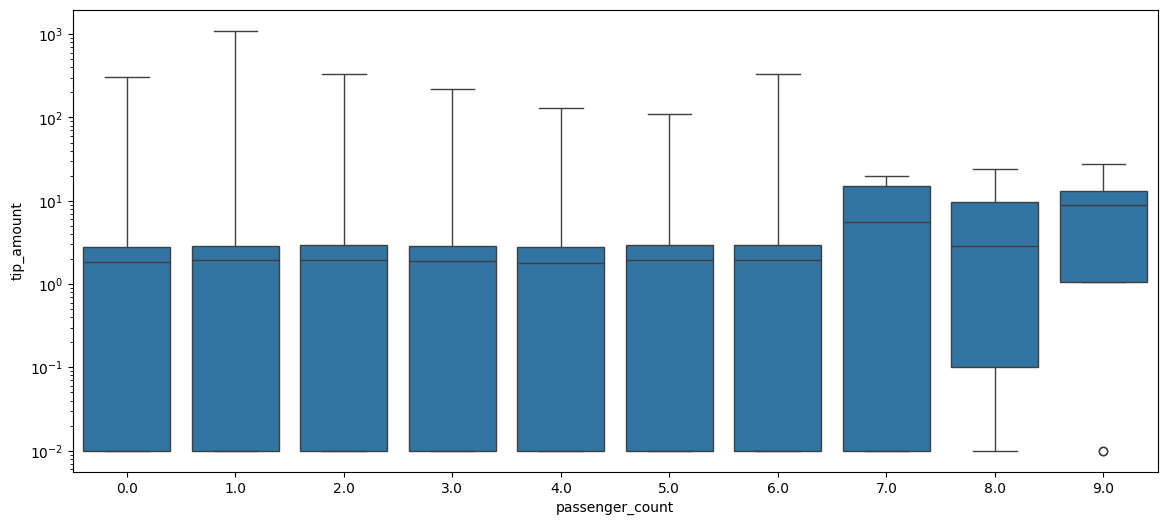

In [7]:
plt.figure(figsize=(14, 6))
sns.boxplot(data=df, y=df.tip_amount + 0.01, x="passenger_count", log_scale=True)
plt.show()

Видим, что поведение пассажиров в количестве от 0 до 5 практически не отличается, при этом начиная с 7 медиана увеличивается. Наверное, это связано с изменением типа авто и цели поездки, например - свадебный лимузин.

Попробуем визуализировать зависимость от обоих факторов через heatmap:

In [8]:
def tips_heatmap(base, rng_lo, rng_hi, col_list):

    tips_med = pd.DataFrame(columns=[0,1,2,3,4,5,6,7,8,9])
    tips_mean = pd.DataFrame(columns=[0,1,2,3,4,5,6,7,8,9])
    list_dist = []
    ind = 0

    for p in range(rng_lo, rng_hi):
        lo = base**p
        hi = base**(p + 1)
        dist = (lo + hi) / 2
        row_med = [ ]
        row_mean = [ ]
        list_dist.append(round(dist, 2))
    
        for n_pass in range(0, 10):
            df_slice = df[df.passenger_count == n_pass][lo <= df.trip_distance][df.trip_distance < hi].tip_amount
            row_med.append(df_slice.median())
            row_mean.append(df_slice.mean())
        tips_med.loc[ind] = row_med
        tips_mean.loc[ind] = row_mean
        ind += 1
    
    cmap = sns.diverging_palette(230, 20, as_cmap=True)

    plt.figure()
    sns.heatmap(tips_med[col_list], cmap = cmap, yticklabels=list_dist)
    plt.title("Медиана чаевых по срезам")
    plt.xlabel("Количество пассажиров")
    plt.ylabel("Расстояние")
    plt.show()
    plt.figure()
    sns.heatmap(tips_mean[col_list], cmap = cmap, yticklabels=list_dist)
    plt.title("Среднее чаевых по срезам")
    plt.xlabel("Количество пассажиров")
    plt.ylabel("Расстояние")
    plt.show()

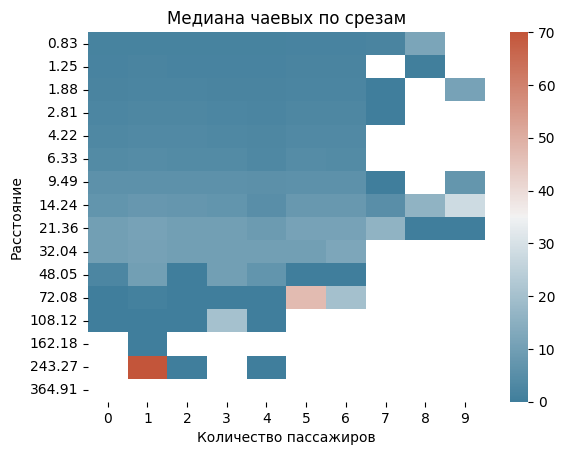

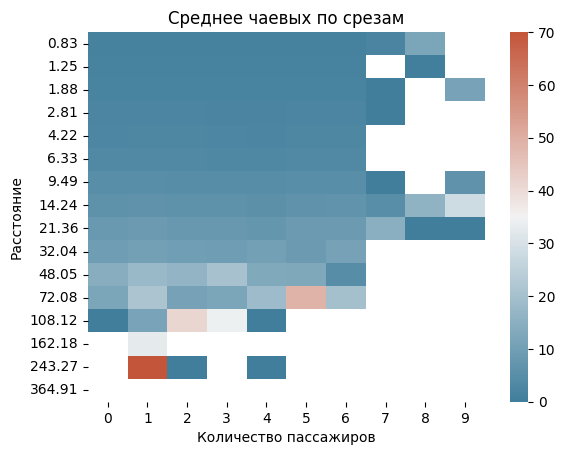

In [9]:
tips_heatmap(1.5, -1, 15, [0,1,2,3,4,5,6,7,8,9])

Белые клетки соответствуют значениям NaN - в них не попадает ни одного значения из датасета. Видим, что для passanger_count >= 7 данных мало. Проверим это:

In [10]:
print("Число поездок с количеством пассажиров от 7:", df.passenger_count[df.passenger_count >= 7].count())
print("Число поездок с количеством пассажиров до 7:", df.passenger_count[df.passenger_count < 7].count())
print("Число поездок с количеством пассажиров 6:   ", df.passenger_count[df.passenger_count == 6].count())

Число поездок с количеством пассажиров от 7: 32
Число поездок с количеством пассажиров до 7: 6271988
Число поездок с количеством пассажиров 6:    131778


Таким образом, у нас всего 32 таких поездки из 6 с лишним млн. Поэтому исключим их из рассмотрения.
Также, привлекают внимание 3 клетки с повышенными значениями. Проверим, сколько значений попадает в них:

In [11]:
print(df[df.passenger_count == 5][1.5**10 <= df.trip_distance][df.trip_distance < 1.5**11].tip_amount)
print()
print(df[df.passenger_count == 2][1.5**11 <= df.trip_distance][df.trip_distance < 1.5**12].tip_amount)
print()
print(df[df.passenger_count == 1][1.5**13 <= df.trip_distance][df.trip_distance < 1.5**14].tip_amount)

317929     54.26
699577     40.00
3471982    64.11
6331181    38.24
Name: tip_amount, dtype: float64

486968       0.00
592594       0.00
5758228     54.28
5799184    151.40
6035286      0.00
Name: tip_amount, dtype: float64

1442784    70.0
Name: tip_amount, dtype: float64


Вторая и третья клетки это очевидно outliers, которые можно игнорировать, а с первой клеткой непонятно. Это могут быть как outliers, так и тенденция, что группа из 5 человек при поездке на сравнительно длинную дистанцию готова платить повышенные чаевые. Возможно, это связано с классом автомобиля, т.к. в обычный седан помещается до 4 человек. Также возможно, что на этом расстоянии от Нью-Йорка находится какой-то специальный объект.
Теперь исключим эти 3 клетки, чтобы лучше видеть оставшуюся картину.

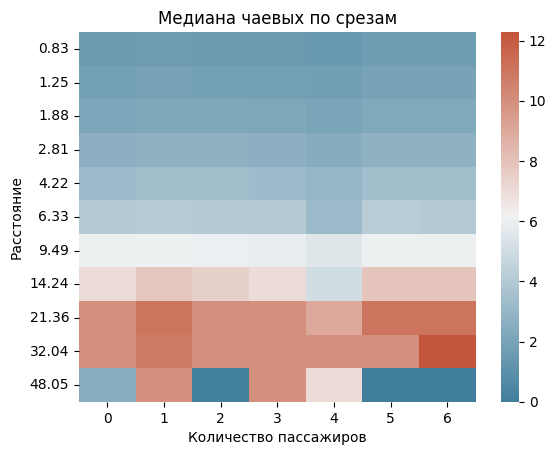

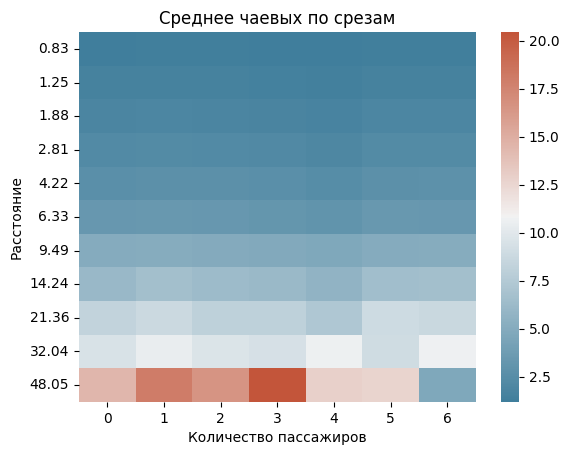

In [12]:
tips_heatmap(1.5, -1, 10, [0,1,2,3,4,5,6])

Мы видим плавное повышение чаевых до расстояний примерно 30 (миль?), а затем начинается хаотичное поведение, связанное с малым количеством данных при увеличении расстояния. Отдельно выделяется столбец с 4 пассажирами, возможно они были недовольны, что на вызов для четверых приехал обычный седан и троих запихнули назад, а они ожидали например стретч или минивэн, и поэтому дали меньше чаевых. Менее выраженная тенденция - увеличение чаевых от одного пассажира, особенно при более длительных поездках. Возможно, если пассажир один, он будет разговаривать с водителем, особенно в более длительной поездке, и в итоге на эмоциях оставит больше чаевых. Если же пассажиров два и более, они будут разговаривать друг с другом, а не с водителем.

Выводы:
    
* Для поездок с числом пассажиров от 7 данных для анализа недостаточно. Для поездок с числом пассажиров менее 7 величина чаевых практически не зависит от количества пассажиров. Исключения: четверо пассажиров оставляют меньше чаевых (на 5-25%), а один пассажир оставляет больше чаевых (до 10%).

* Для поездок до ~30 миль (для медианы) и до ~50 миль (для среднего) прослеживается прямая зависимость чаевых от расстояния, а дальше начинает сказываться нехватка данных.